# Machine Learning Pipeline - Scoring New Data

Let's imagine that a colleague from the business department comes and asks us to score the data from last months customers. They want to be sure that our model is working appropriately in the most recent data that the organization has.

**How would you go about to score the new data?** Try to give it a go. There is more than 1 way of doing it.

Below we present one potential solution.

What could we have done better?

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats

# to save the model
import joblib

In [2]:
# load the unseen / new dataset
data = pd.read_csv(r'../../Raw_Data/test.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [3]:
# drop the id variable

data.drop('Id', axis=1, inplace=True)

data.shape

(1459, 79)

# Feature Engineering

First we need to transform the data. Below the list of transformations that we did during the Feature Engineering phase:

1. Missing values
2. Temporal variables
3. Non-Gaussian distributed variables
4. Categorical variables: remove rare labels
5. Categorical variables: convert strings to numbers
6. Put the variables in a similar scale

## Missing values

### Categorical variables

- Replace missing values with the string "missing" in those variables with a lot of missing data. 
- Replace missing data with the most frequent category in those variables that contain fewer observations without values. 

In [4]:
# first we needed to cast MSSubClass as object

data['MSSubClass'] = data['MSSubClass'].astype('O')

In [5]:
# list of different groups of categorical variables

with_string_missing = ['Alley', 'FireplaceQu',
                       'PoolQC', 'Fence', 'MiscFeature']

# ==================
# we copy this dictionary from the Feature-engineering notebook
# note that we needed to hard-code this by hand

# the key is the variable and the value is its most frequent category

# what if we re-train the model and the below values change?
# ==================

with_frequent_category = {
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1': 'Unf',
    'BsmtFinType2': 'Unf',
    'Electrical': 'SBrkr',
    'GarageType': 'Attchd',
    'GarageFinish': 'Unf',
    'GarageQual': 'TA',
    'GarageCond': 'TA',
}

In [6]:
# replace missing values with new label: "Missing"

data[with_string_missing] = data[with_string_missing].fillna('Missing')

In [7]:
# replace missing values with the most frequent category

for var in with_frequent_category.keys():
    data[var].fillna(with_frequent_category[var], inplace=True)

### Numerical variables

To engineer missing values in numerical variables, we will:

- add a binary missing value indicator variable
- and then replace the missing values in the original variable with the mean

In [8]:
# this is the dictionary of numerical variable with missing data
# and its mean, as determined from the training set in the
# Feature Engineering notebook

# note how we needed to hard code the values

vars_with_na = {
    'LotFrontage': 69.87974098057354,
    'MasVnrArea': 103.7974006116208,
    'GarageYrBlt': 1978.2959677419356,
}

In [9]:
# replace missing values as we described above

for var in vars_with_na.keys():

    # add binary missing indicator (in train and test)
    data[var + '_na'] = np.where(data[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    data[var].fillna(vars_with_na[var], inplace=True)

data[vars_with_na].isnull().sum()

C:\Users\vanho\AppData\Local\Temp\ipykernel_11208\2265030139.py:12: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  data[vars_with_na].isnull().sum()


LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [10]:
# check the binary missing indicator variables

data[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


## Temporal variables

### Capture elapsed time

We need to capture the time elapsed between those variables and the year in which the house was sold:

In [11]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [12]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

In [13]:
# now we drop YrSold
data.drop(['YrSold'], axis=1, inplace=True)

## Numerical variable transformation

### Logarithmic transformation

We will transform with the logarithm the positive numerical variables in order to get a more Gaussian-like distribution.

In [14]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    data[var] = np.log(data[var])

### Yeo-Johnson transformation

We will apply the Yeo-Johnson transformation to LotArea.

In [15]:
# note how we use the lambda that we learned from the train set
# in the notebook on Feature Engineering.

# Note that we need to hard code this value

data['LotArea'] = stats.yeojohnson(data['LotArea'], lmbda=0.017755558882009546) #SMALL CHANGE IN LMBDA VAL

### Binarize skewed variables

There were a few variables very skewed, we would transform those into binary variables.

In [16]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed:
    
    # map the variable values into 0 and 1
    data[var] = np.where(data[var]==0, 0, 1)

## Categorical variables

### Apply mappings

We remap variables with specific meanings into a numerical scale.

In [17]:
# re-map strings to numbers, which determine quality

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    data[var] = data[var].map(qual_mappings)

In [18]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

data[var] = data[var].map(exposure_mappings)

In [19]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    data[var] = data[var].map(finish_mappings)

In [20]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

data[var] = data[var].map(garage_mappings)

In [21]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

data[var] = data[var].map(fence_mappings)

In [22]:
# check absence of na in the data set

with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

with_null

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea',
 'SaleType']

**Surprise**

There are quite a few variables with missing data!!

In [23]:
# did those have missing data in the train set?

[var for var in with_null if var in list(
    with_frequent_category.keys())+with_string_missing+list(vars_with_na.keys())]

[]

**IMPORTANT**

In the new data, we have a bunch of variables that contain missing information, that we did not anticipate.

### Removing Rare Labels

For the remaining categorical variables, we will group those categories that are present in less than 1% of the observations into a "Rare" string.

In [24]:
# create a dictionary with the most frequent categories per variable

# note the amount of hard coding that I need to do.

# Can you think of an alternative? Perhaps we could have save this as a numpy pickle
# and load it here, instead of hard-coding.

# But that means that we need to go back to the Feature Engineering notebook, and change
# the code so that we store the pickle. So there is still some code changes that we need

frequent_ls = {
    'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
    'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
                     'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
                     'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
                     'Somerst', 'StoneBr', 'Timber'],

    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],

    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],

    'MasVnrType': ['BrkFace', 'None', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['Missing'],
    'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
}

In [25]:
for var in frequent_ls.keys():
    
    # replace rare categories by the string "Rare"
    data[var] = np.where(data[var].isin(
        frequent_ls[var]), data[var], 'Rare') #added [var] in the code

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. 

In [26]:
# we need the mappings learned from the train set. Otherwise, our model is going
# to produce inaccurate results

# note the amount of hard coding that we need to do.

# Can you think of an alternative? 

# Perhaps we could have save this as a numpy pickle
# and load it here, instead of hard-coding.

# But that means that we need to go back to the Feature Engineering notebook, and change
# the code so that we store the pickle. So there is still some code changes that we need

ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                     'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                     'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                     'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                     'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
    
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,
                   '70': 7, '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
}

In [27]:
for var in ordinal_mappings.keys():

    ordinal_label = ordinal_mappings[var]

    # use the dictionary to replace the categorical strings by integers
    data[var] = data[var].map(ordinal_label)

In [28]:
# check absence of na in the data set

with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

len(with_null)

8

In [29]:
# there is missing data in a lot of the variables.

# unfortunately, the scaler wil not work with missing data, so
# we need to fill those values

# in the real world, we would try to understand where they are coming from
# and why they were not present in the training set

# here I will just fill them in quickly to proceed with the demo

data.fillna(0, inplace=True)

## Feature Scaling

We will scale features to the minimum and maximum values:

In [30]:
# load the scaler we saved in the notebook on Feature Engineering

# fortunataly, we were smart and we saved it, but this is an easy step
# to forget

scaler = joblib.load('minmax_scaler.joblib') 

data = pd.DataFrame(
    scaler.transform(data),
    columns=data.columns
)

In [31]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.083333,0.50,0.495064,0.417574,1.0,1.0,0.000000,0.333333,1.0,0.0,...,0.0,0.75,1.0,0.0,0.454545,0.666667,0.75,0.0,0.0,0.0
1,0.083333,0.75,0.499662,0.457509,1.0,1.0,0.333333,0.333333,1.0,0.5,...,0.0,0.00,0.0,1.0,0.454545,0.666667,0.75,0.0,0.0,0.0
2,0.083333,0.75,0.466207,0.451441,1.0,1.0,0.333333,0.333333,1.0,0.0,...,0.0,0.75,1.0,0.0,0.181818,0.666667,0.75,0.0,0.0,0.0
3,0.083333,0.75,0.485693,0.387965,1.0,1.0,0.333333,0.333333,1.0,0.0,...,0.0,0.00,1.0,0.0,0.454545,0.666667,0.75,0.0,0.0,0.0
4,0.083333,0.75,0.265271,0.255026,1.0,1.0,0.333333,1.000000,1.0,0.0,...,0.0,0.00,1.0,0.0,0.000000,0.666667,0.75,0.0,0.0,0.0


In [32]:
# load the pre-selected features
# ==============================

features = pd.read_csv('selected_features.csv')
features = features['0'].to_list() 

# reduce the train and test set to the selected features
data = data[features]

data.shape

(1459, 36)

Note that we engineered so many variables, when we are actually going to feed only 31 to the model.

**What could we do differently?**

We could have, of course, engineered only the variables that we are going to use in the model. But that means:

- identifying which variables we need
- identifying which transformation we need per variable
- redefining our dictionaries accordingly
- retraining the MinMaxScaler only on the selected variables (at the moment, it is trained on the entire dataset)

That means, that we need to create extra code to train the scaler only on the selected variables. Probably removing the scaler from the Feature Engineering notebook and passing it onto the Feature Selection one.

We need to be really careful in re-writing the code here to make sure we do not forget or engineer wrongly any of the variables.

<Axes: >

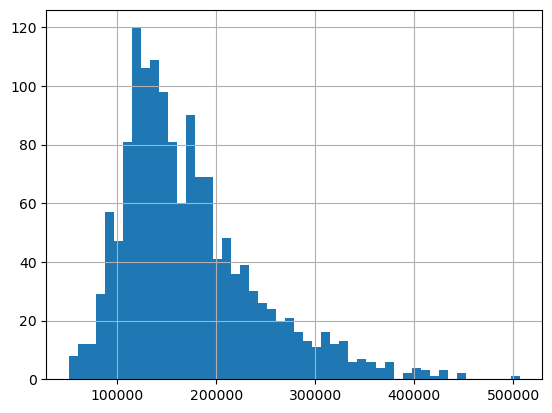

In [33]:
# now let's load the trained model

lin_model = joblib.load('linear_regression.joblib') 

# let's obtain the predictions
pred = lin_model.predict(data)

# let's plot the predicted sale prices
pd.Series(np.exp(pred)).hist(bins=50)

What shortcomings, inconvenience and problems did you find when scoring new data?

# List of problems

- re-wrote a lot of code ==> repetitive
- hard coded a lot of parameters ==> if these change we need to re-write them again
- engineered a lot of variables that we actually do not need for the model
- additional variables present missing data, we do not know what to do with them

We can minimize these hurdles by using Open-source. And we will see how in the next videos.